<a href="https://colab.research.google.com/github/niqolla/bayesian_statistics_bioinformatics/blob/main/AST_A02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing and importing

In [ ]:
%%capture
!pip install Theano==1.0.4
!pip install pymc3==3.8
!pip install arviz==0.6.1

In [ ]:
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
import theano.tensor as tt
from sklearn.mixture import GaussianMixture

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/datasets/AST/geneExpVsProliferation.tsv', sep='\t')
df.rename(columns={'Unnamed: 0':'Cell'}, inplace=True)

In [ ]:
print('Shape:', df.shape, '\nNulls:')
pd.DataFrame(df.isnull().sum()).T


Shape: (1000, 10) 
Nulls:


,Cell,GeneA,GeneB,GeneC,GeneD,GeneE,GeneF,GeneG,GeneH,DoublingTime
0,0,0,0,0,0,0,0,0,0,0


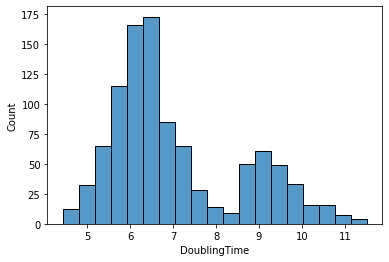

In [ ]:
sns.histplot(df.DoublingTime)

    The distribution of the 'DoublingTime' looks like two normal distributions.

# 1
----------------------------------------------------------
Propose a threshold to classify the cells as "healthy" and "cancer" cells. Perform a t-test to indicate the significance of your conclusions. Explain carefully what a t-test is and the conclusions that you have drawn.

## Frequentist Approach

### GMM

I will start with a classic frequentist approach.

In [ ]:
freq_approach = pd.DataFrame()
freq_approach['DoublingTime'] = df['DoublingTime']

Here, I create a new df which only contains the DoublingTime field. This is the field of interest. Beause it looks like two normal distributions, I will use the Gaussian Mixture Model to separate the enteries for that field into 2 groups (n_components=2). I will add another field into the new df, which will hold the value for the group in which the entery belongs.

In [ ]:
# from sklearn.mixture import GaussianMixture

# Fit a Gaussian Mixture Model with two components
gmm = GaussianMixture(n_components=2).fit(freq_approach['DoublingTime'].to_numpy().reshape(-1, 1))

# Assign each row to one of the two groups
labels = gmm.predict(freq_approach['DoublingTime'].to_numpy().reshape(-1, 1))

# Adding a labels column with the appropriate labes for the groups they have gotten classified in 
freq_approach['labels'] = labels

Visually it seems like the GGM did a good job and the two groups are correctly classified. 

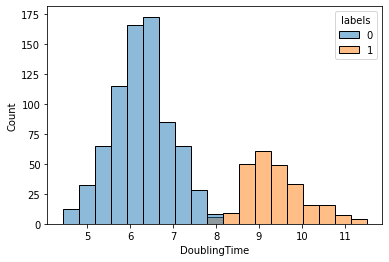

In [ ]:
sns.histplot(data=freq_approach, x='DoublingTime', hue='labels')

### Describing the two groups

Here, I create two arrays that hold the DoublingTime values for the 2 groups. 

In [ ]:
group1 = np.array(freq_approach.loc[freq_approach['labels']==0, 'DoublingTime'])
group2 = np.array(freq_approach.loc[freq_approach['labels']==1, 'DoublingTime'])

In [ ]:
if group2[0] < group1[0]:
  max_lower = max(group2)
  min_upper = min(group1)
else:
  max_lower = max(group1)
  min_upper = min(group2)

print(f'The maximumum of the group bellow is: {max_lower}, and the minimum of the group above is: {min_upper}\n\
so I would propose having the mean of these values as a treshold value, which is: {(max_lower+min_upper)/2} .\n\
It is important to keep in mind that this values are values that have been drawn from the samples, not from the population.')

The maximumum of the group bellow is: 7.89, and the minimum of the group above is: 7.93
so I would propose having the mean of these values as a treshold value, which is: 7.91 .
It is important to keep in mind that this values are values that have been drawn from the samples, not from the population.


In [ ]:
i = 1
for group in [group1,group2]:
  print(f'Group: {i}, has N = {len(group)}, mean = {group.mean()}, variance = {group.var()}')
  i += 1
print('There is homoscedasticity')

Group: 1, has N = 749, mean = 6.253991989319092, variance = 0.4411219812442402
Group: 2, has N = 251, mean = 9.39378486055777, variance = 0.484016352121395
There is homoscedasticity


### T-test

    A t-test is a statistical test used to determine if there is a significant 
    difference between the means of two groups. It compares the means of two 
    independent samples to determine if they are statistically different from 
    each other.

    When conducting a t-test, we calculate a t-value and a corresponding 
    p-value. The t-value represents the difference between the means of the two 
    groups, relative to the variability within the groups. The p-value 
    represents the probability of obtaining a t-value as extreme as the one we 
    calculated, assuming that there is no difference between the groups.

    If the p-value is less than the chosen significance level (usually 0.05), 
    we reject the null hypothesis that there is no difference between the means 
    of the two groups. In other words, we conclude that there is a significant 
    difference between the means of the two groups.

    When the p-value is very small (i.e., less than 0.001), we conclude that 
    the probability of obtaining the observed t-value by chance alone is 
    extremely low. This suggests that the observed difference between the means 
    of the two groups is not likely due to chance or random variation, but 
    rather represents a true difference between the groups. Therefore, we can 
    be highly confident that the difference between the means is statistically 
    significant.

In [ ]:
%%capture
!pip install pingouin

In [ ]:
import scipy.stats as stats 
import pingouin as pg

In [ ]:
# result = stats.ttest_ind(a=group1, b=group2, equal_var=True)
result = pg.ttest(group1, group2, correction=True)
print(result)

                T         dof alternative          p-val           CI95%  \
T-test -62.474309  412.700415   two-sided  1.811243e-212  [-3.24, -3.04]   

         cohen-d BF10  power  
T-test  4.666063  inf    1.0  


$H_0 : μ_1 = μ_2$ 

$H_A : μ_1$ $\not=$ $μ_2$

We have sufficient evidence to refuse $H_0$ because $p = 1.811243 * 10^{-212} $

### Conclusions:
There is a statistical difference between the two groups. 
The proposed treshold is 7.91. (However, this is a statistic, not a parameter, so it can be applied to this dataset, but we don't know if it can be generalised. In the baysian approach (below) we will estiamte this parameter and will be able to generalize it.).

## Bayesian Approach 

In [ ]:
def _hist(data, label, **kwargs):
  return plt.hist(data, bins=40, histtype='stepfilled', alpha=.95, label=label, **kwargs)

In [ ]:
data = df.DoublingTime

### Creating $model_1$:
*   $tau$ is the treshould value and, because it's time, it can be between 0 and the maximum recoreded time in the dataset.
*   $mean_1$ and $mean_2$ are the means of the two distributions
> * $mean_1$ aprears to be around 6
> * $mean_2$ arround 9

*   $sigma_1$ and $sigma_2$ are the standard deviations of the two distributions (max set at 10, because they appear to be smaller)

The two distribtions are normal (observation = pm.Normal). The observations are divided in 2 groups depending on the vaule for the doubling time. If the DoublingTime for a give observation is smaller than $tau$ set it to have $mean_1$ and $sigma_1$, ei. distribution 1; if it's larger, then $mean_2$ and $sigma_2$, distribution 2.

In [ ]:
with pm.Model() as model1:
  # Define the switch point between distributions
  tau = pm.Uniform("tau", lower=0, upper=max(data))
  
  # Define the mean and standard deviation for each distribution
  mean1 = pm.Normal("mean1", mu=6, sigma=2)
  mean2 = pm.Normal("mean2", mu=9, sigma=2)
  sigma1 = pm.HalfNormal("sigma1", sigma=10)
  sigma2 = pm.HalfNormal("sigma2", sigma=10)

  # For each observation decide the distribution 
  # given the doubling time (data) -> if its smaller than tau
  # set it to have mean1 and sigma1; if it's larger then mean2 and sigma2
  mean = pm.math.switch(tau > data, mean1, mean2)
  sigma = pm.math.switch(tau > data, sigma1, sigma2)
  observation = pm.Normal("obs", mean, sigma, observed=data)

  trace1 = pm.sample(15000, tune=5000, step=pm.Metropolis())


Sampling chain 1, 0 divergences: 100%|██████████| 20000/20000 [00:21<00:00, 917.10it/s] 


/usr/local/lib/python3.8/dist-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSuppli

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0369031160>,
      dtype=object)

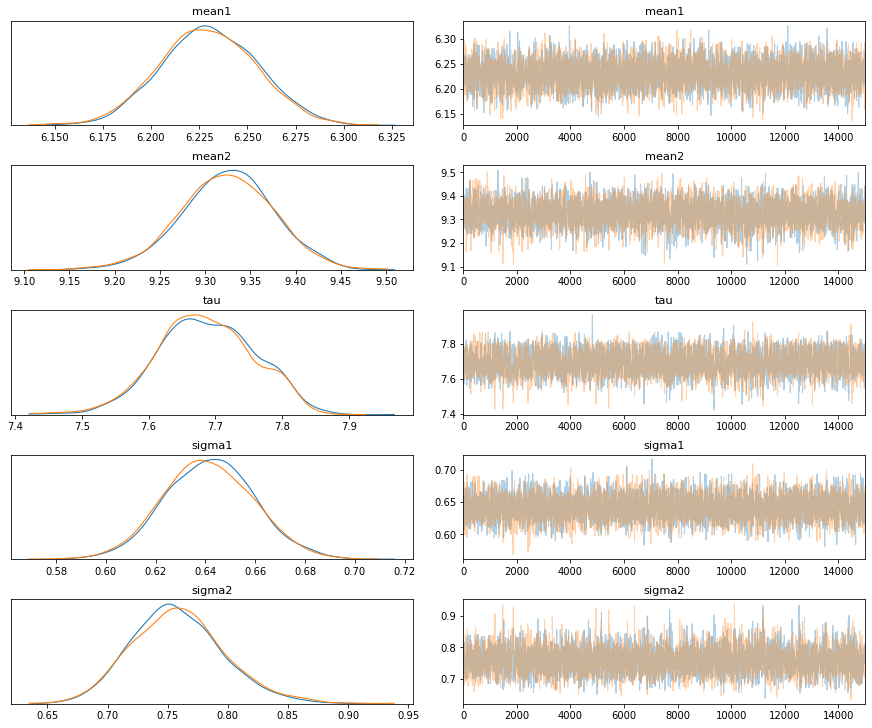

In [ ]:
pm.traceplot(trace1)

    We can see that the parameters converge.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0365143ac0>,
      dtype=object)

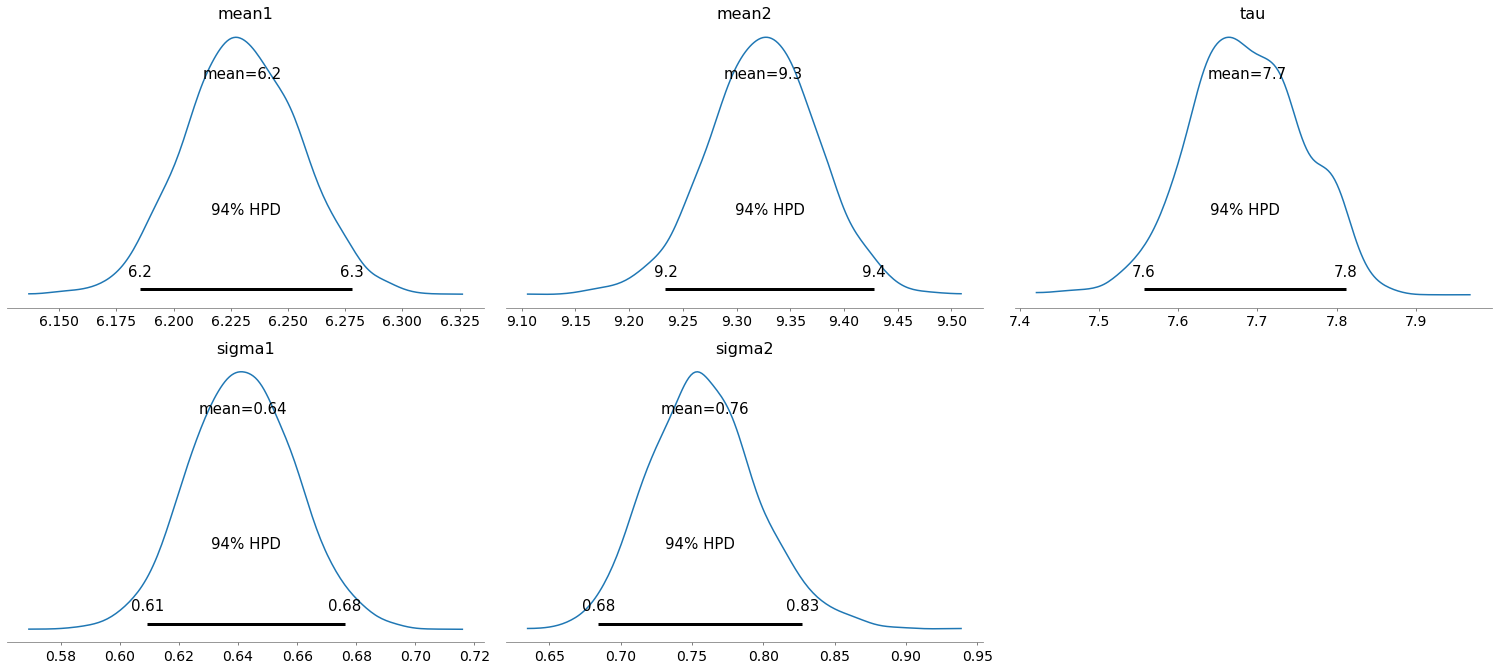

In [ ]:
pm.plot_posterior(trace1)

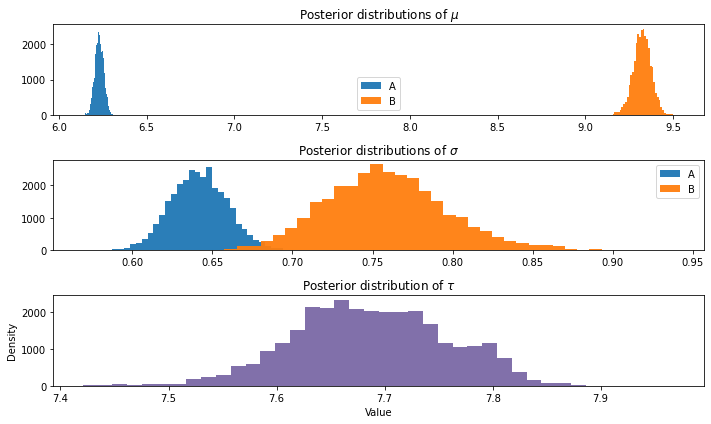

In [ ]:
plt.figure(figsize=(10, 6))

ax = plt.subplot(3,1,1)
_hist(trace1.mean1, 'A')
_hist(trace1.mean2, 'B')
plt.legend()
plt.title('Posterior distributions of $\mu$')

ax = plt.subplot(3,1,2)
_hist(trace1.sigma1, 'A')
_hist(trace1.sigma2, 'B')
plt.legend()
plt.title('Posterior distributions of $\sigma$')

ax = plt.subplot(3,1,3)
_hist(trace1.tau,'', color='#7A68A6')
plt.title(r'Posterior distribution of $\tau$')
plt.xlabel('Value')
plt.ylabel('Density')
plt.tight_layout()

    Here we can see the distributions of the posteriors.
    

#### Conclusions:

In [ ]:
print("PARAMETER ESTIMATES\nThe means are:")
print("Mean1 = ", trace1.mean1.mean())
print("Mean2 = ", trace1.mean2.mean())
print("\nThe treshold is:")
print("Tau = ", trace1.tau.mean())

PARAMETER ESTIMATES
The means are:
Mean1 =  6.230058088632974
Mean2 =  9.324418749790242

The treshold is:
Tau =  7.68668650206746


In the t-test (frequentist approach) we have the values for the statistics. From them, the variance and the degrees of freedom we can see if they are statistically different. Meaning, if we actually knew the population parameters, would they be different. 

In the bayesian approach, we actually approximate the parameters themselves. From the plot above, we can see that the distributions for the means are different and do not overlap. Therefore, we can say that the groups are statistically different.

----

### Creating $model_2$:

Modified from $Bayesian Methods for Hackers - Chapter 7: Bayesian$ $A/B$ $Testing$

This model does not find the value of the treshold, however it estimates the means and the variances of the two distributions. It was originally published in: Kruschke, John K. “Bayesian Estimation Supersedes the t test,” Journal of Experimental Psychology: General, 142, no. 2 (2013): 573–603.

The pooled mean is the mean of the entire column and the pooled standard distribution is the std of the entire column. The two groups are labeled as A and B. They are set to follow a T-distribution. The reason for this is because the T-distribution is a good approximate for the normal distribution and because of the extenden tails (defined by the $\nu$ parameter), the t-distribution can also account for any possible outliers [Fig1]. 

The $\nu$ parameter describes the elongation of the tails. The higher it is, the better the distribution follows a normal one. The smaller it is, the more extended the tails are [Fig2].


[Fig1]

![picture](https://drive.google.com/uc?export=view&id=1eNcchfQTlqjYqRlmPV5wbgdBNqiSLwhr)


[Fig2]

![picture](https://drive.google.com/uc?export=view&id=140m9q5QoDu1lm7ZxwF2EApSTkrmcUbBR)



In [ ]:
with pm.Model() as hierarchical_model:
    # Pooled mean and standard deviation priors
    pooled_mean = np.r_[group1, group2].mean()
    pooled_std = np.r_[group1, group2].std()
    tau = 1./np.sqrt(1000.*pooled_std)

    # Group-specific means and standard deviations
    mu_A = pm.Normal("mu_A", mu=pooled_mean, sd=1/np.sqrt(pooled_std))
    mu_B = pm.Normal("mu_B", mu=pooled_mean, sd=1/np.sqrt(pooled_std))
    std_A = pm.Uniform("std_A", lower=pooled_std/1000, upper=1000*pooled_std)
    std_B = pm.Uniform("std_B", lower=pooled_std/1000, upper=1000*pooled_std)

    # Estimate nu from a shifted exponential distribution with parameter equal to 29
    nu = pm.Exponential("nu", lam=1/29) + 1

    # Likelihoods
    obs_A = pm.StudentT("obs_A", nu=nu, mu=mu_A, sd=std_A, observed=group1)
    obs_B = pm.StudentT("obs_B", nu=nu, mu=mu_B, sd=std_B, observed=group2)

    # Sample from the posterior using NUTS sampler
    hierarchical_trace = pm.sample(15000, tune=3000, step=pm.Metropolis())


Sampling chain 1, 0 divergences: 100%|██████████| 18000/18000 [00:21<00:00, 846.35it/s]


/usr/local/lib/python3.8/dist-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSuppli

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0362f764c0>,
      dtype=object)

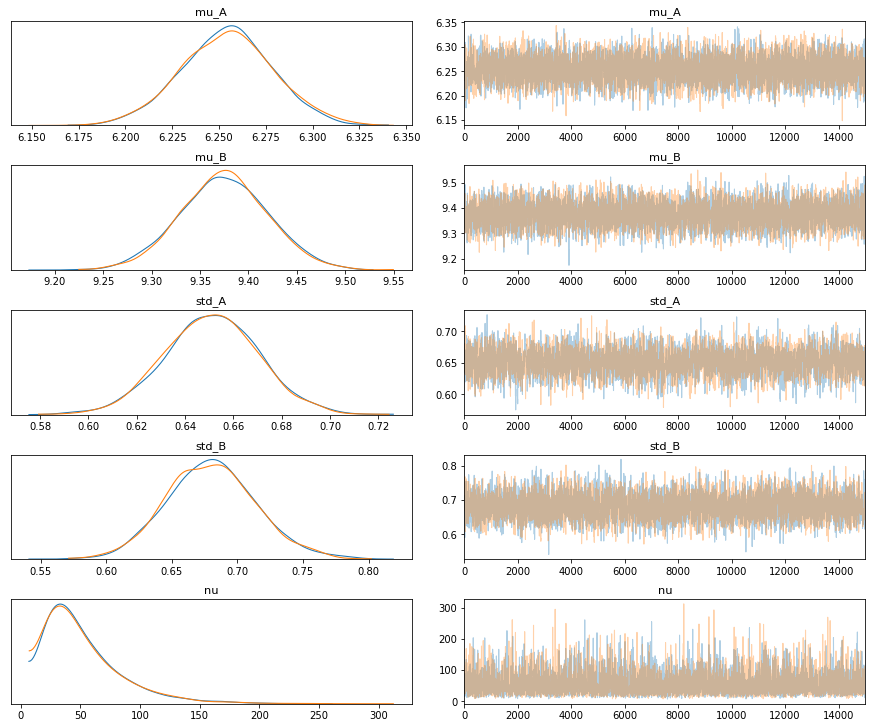

In [ ]:
pm.traceplot(hierarchical_trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f036044f640>,
      dtype=object)

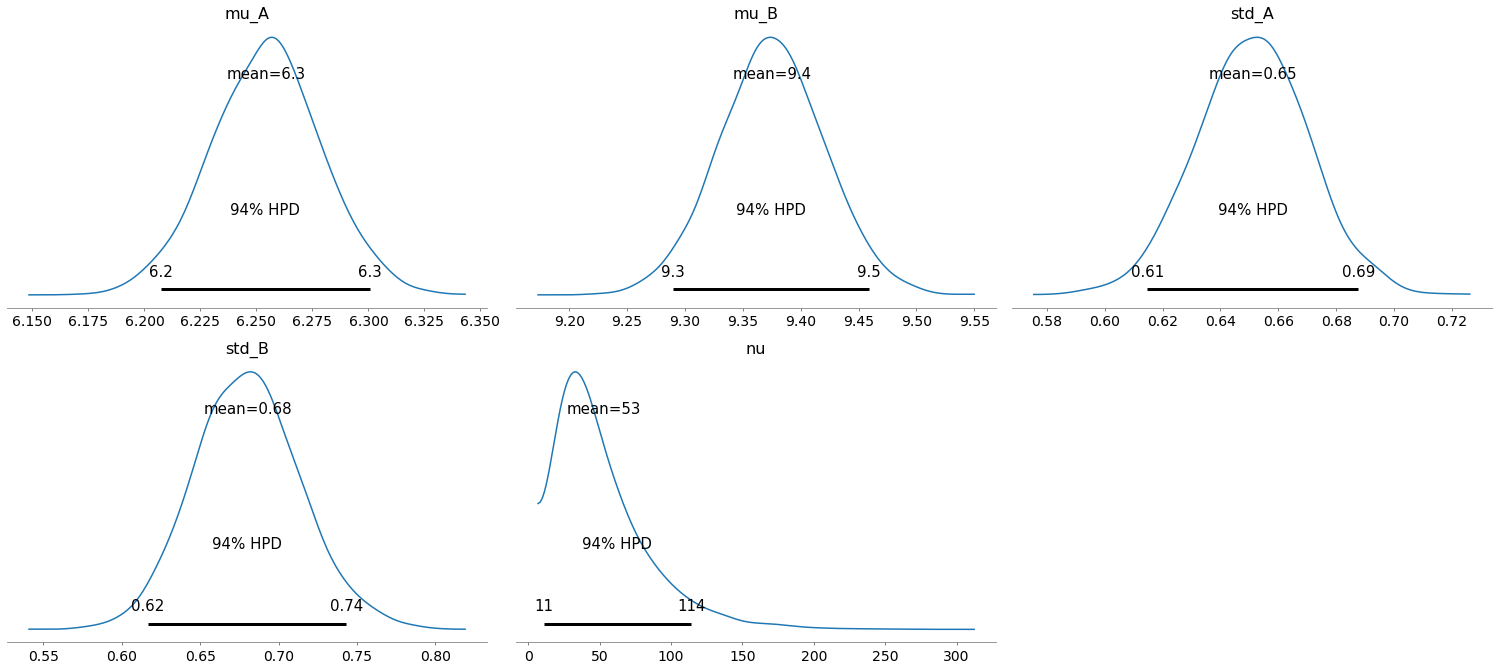

In [ ]:
pm.plot_posterior(hierarchical_trace)

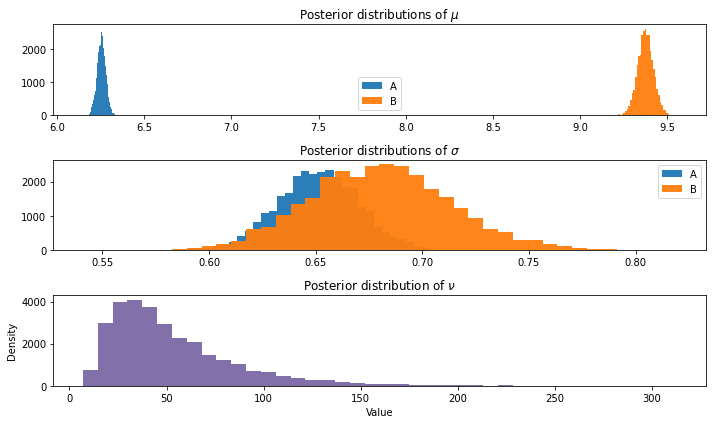

In [ ]:
plt.figure(figsize=(10, 6))

ax = plt.subplot(3,1,1)
_hist(hierarchical_trace.mu_A, 'A')
_hist(hierarchical_trace.mu_B, 'B')
plt.legend()
plt.title('Posterior distributions of $\mu$')

ax = plt.subplot(3,1,2)
_hist(hierarchical_trace.std_A, 'A')
_hist(hierarchical_trace.std_B, 'B')
plt.legend()
plt.title('Posterior distributions of $\sigma$')

ax = plt.subplot(3,1,3)
_hist(hierarchical_trace.nu,'', color='#7A68A6')
plt.title(r'Posterior distribution of $\nu$')
plt.xlabel('Value')
plt.ylabel('Density')
plt.tight_layout()

#### Conclusions: 

In [ ]:
print("PARAMETER ESTIMATES\nThe means are:")
print("Mean1 = ", hierarchical_trace.mu_A.mean())
print("Mean2 = ", hierarchical_trace.mu_B.mean())


PARAMETER ESTIMATES
The means are:
Mean1 =  6.254468928256689
Mean2 =  9.375168218720534


Again, from the plot above, we can see that the distributions for the means are different and do not overlap. Therefore, we can say that the groups are statistically different.

----


#2. 
-------
Construct a model (or more than one) in PyMC3 to test the influence of these marker genes in proliferation. Try to catch which genes influence and which ones do not, which ones "trigger" the doubling time when some threshold is surpassed, etc. Explain carefully the model(s) and your conclusions.

If we suppose that there are no other factors, then the DoublingTime is a function of the expression of all the genes. Therefore, my idea for this exercise is to construct a multiple regression model. 

$DoublingTime = \alpha + \beta_0*GeneA + \beta_1*GeneB$ $+$ $...$

Some genes are expressed highly and some have low expression values. So, with scaled data, the betas would reflect the importance of the genes. 

### EDA and Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to your data
scaler.fit(df)

df_s = pd.DataFrame(scaler.transform(df), columns=[i+'_S' for i in df.columns])

In [ ]:
data_s = df_s['DoublingTime_S']

    Getting a sense of the distribution of the fields and 
    correlations between the fields.

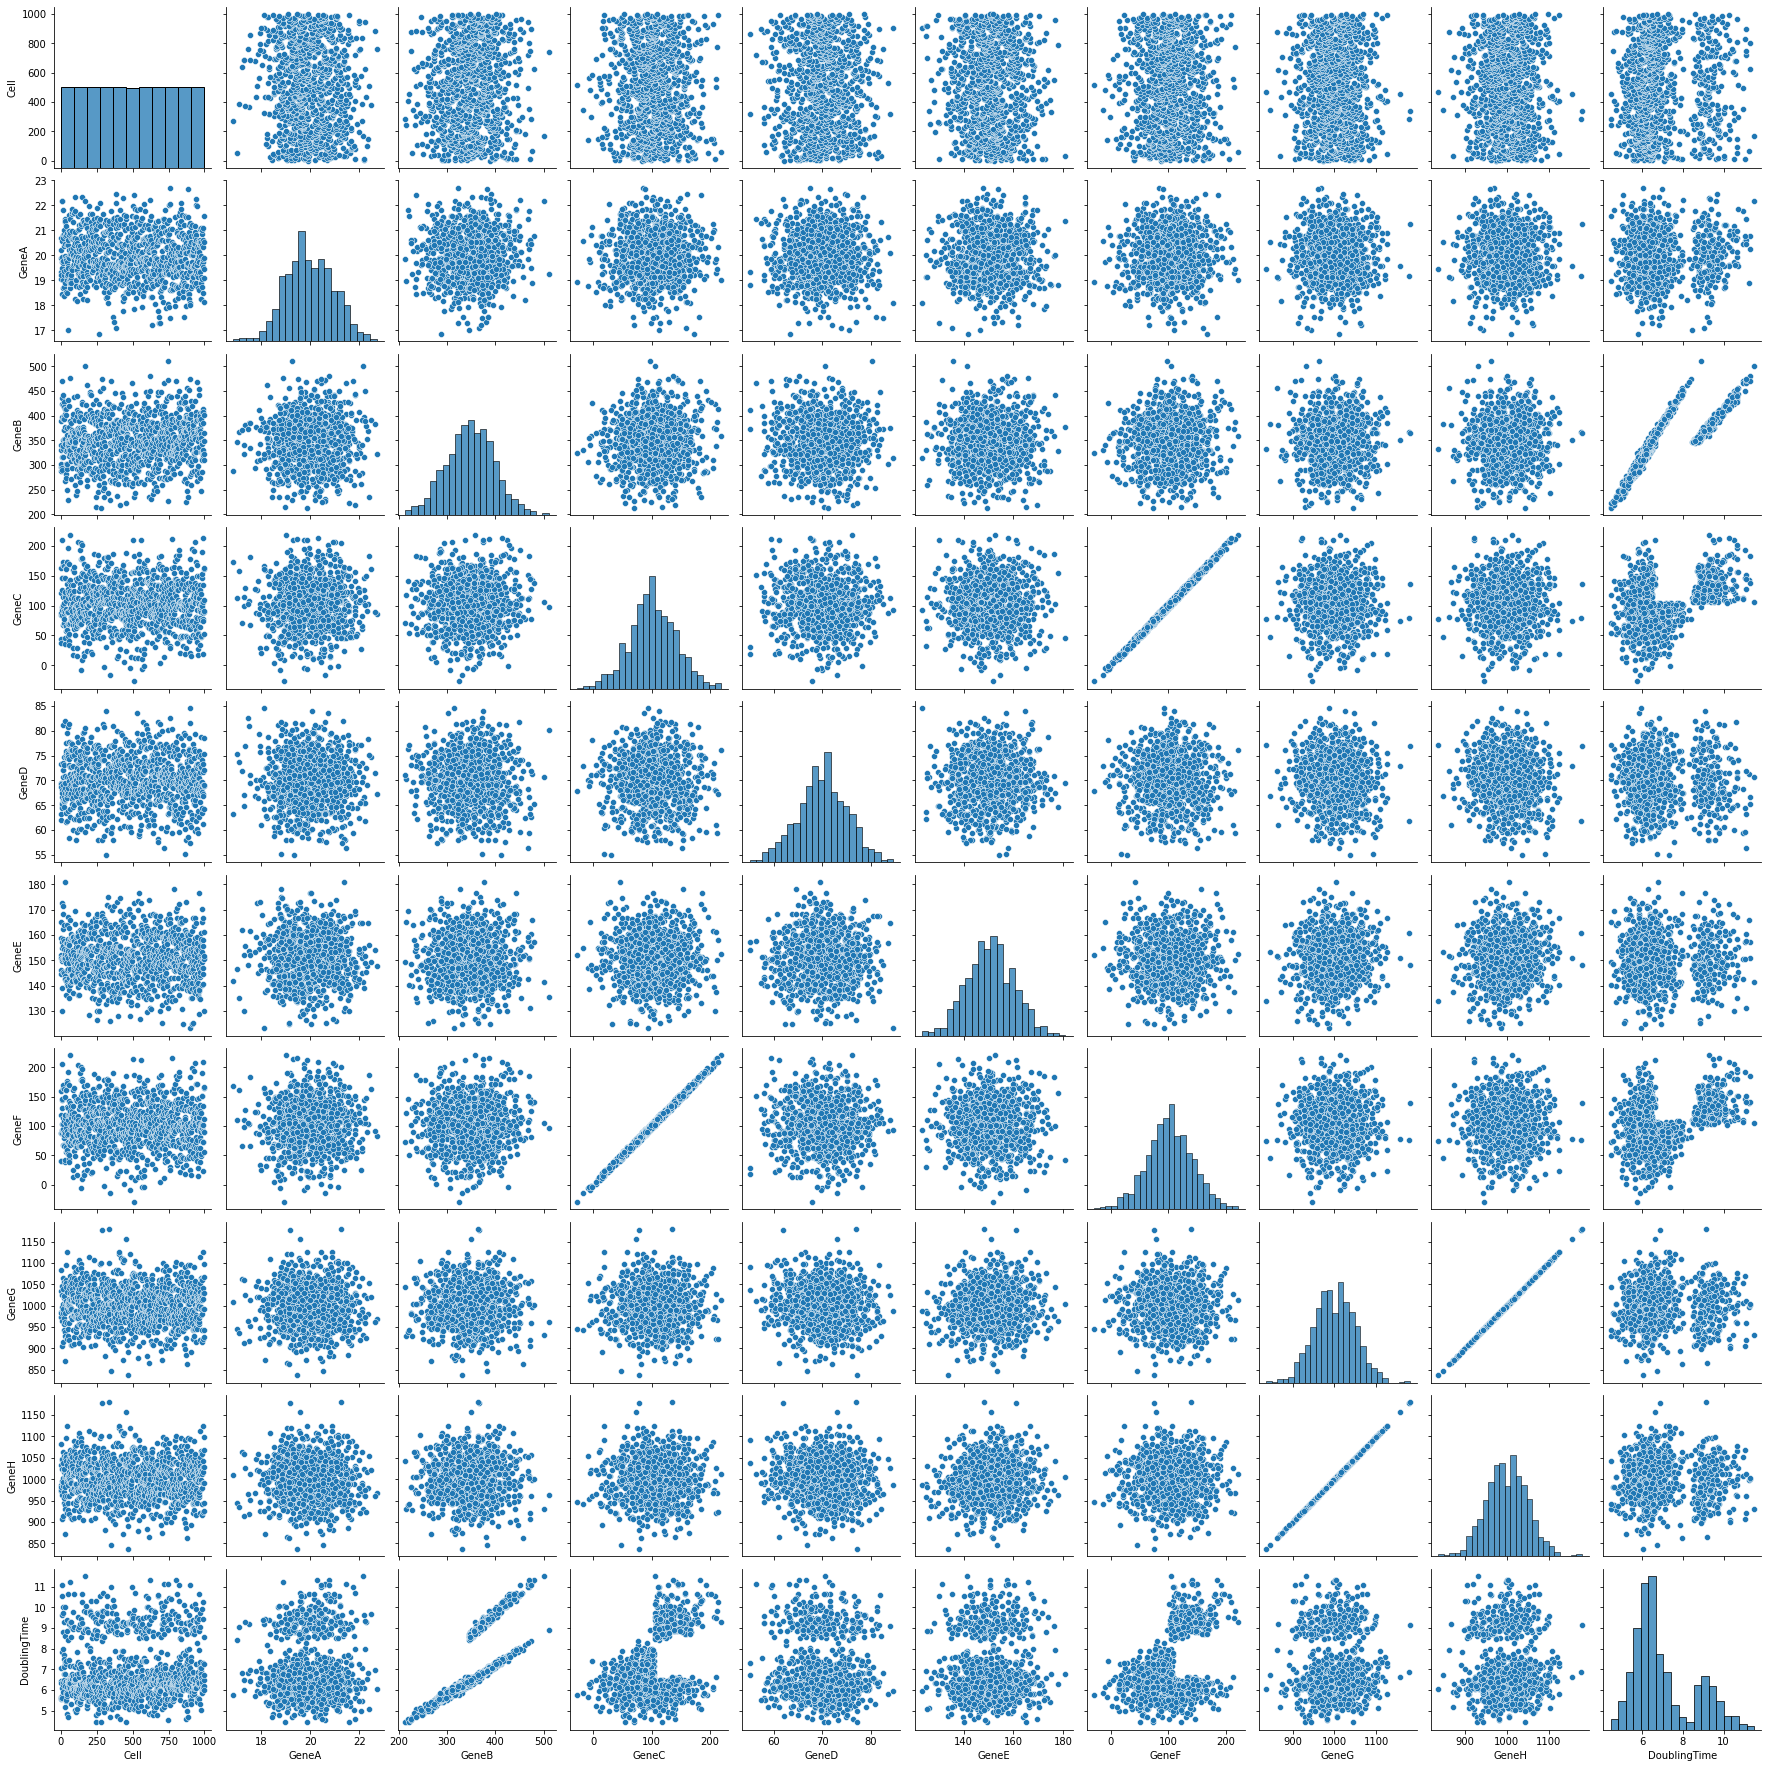

In [ ]:
sns.pairplot(df)

    From the last row, we can see that GeneB has strong correlation with the 
    DoublingTime, and GeneC and GeneF seem to have some also some medium correlation.

    Furthermore, GeneC and GeneF are strongly correlated 
    and GeneG and GeneH as well.

### Modeling

For the linear regression, I will be excluding one element (gene) of the paris of  correlated genes (C and G) for the reasons specified below. 

> Overfitting: Including highly correlated fields in a linear regression model can result in overfitting, where the model fits the noise in the data rather than the underlying relationship. This can result in a model that does not generalize well to new data.

> Multicollinearity: Multicollinearity occurs when two or more independent variables in a regression model are highly correlated with each other. This can cause instability in the model coefficients and make it difficult to interpret the effect of each variable on the dependent variable. Moreover, using all the fiels results in non-converging parameters (I have included that model in the last section "*Faulty Model*").

> Reduced Model Interpretability: Including highly correlated fields in a linear regression model can make it difficult to interpret the effect of each variable on the dependent variable, as the impact of each variable is confounded by the presence of other highly correlated variables. 

In [ ]:
n_predictors = 6
predictors = df_s[['GeneA_S', 'GeneB_S', 'GeneD_S', 'GeneE_S', 'GeneF_S', 'GeneH_S']]

    Checking if the fields have outliers. 

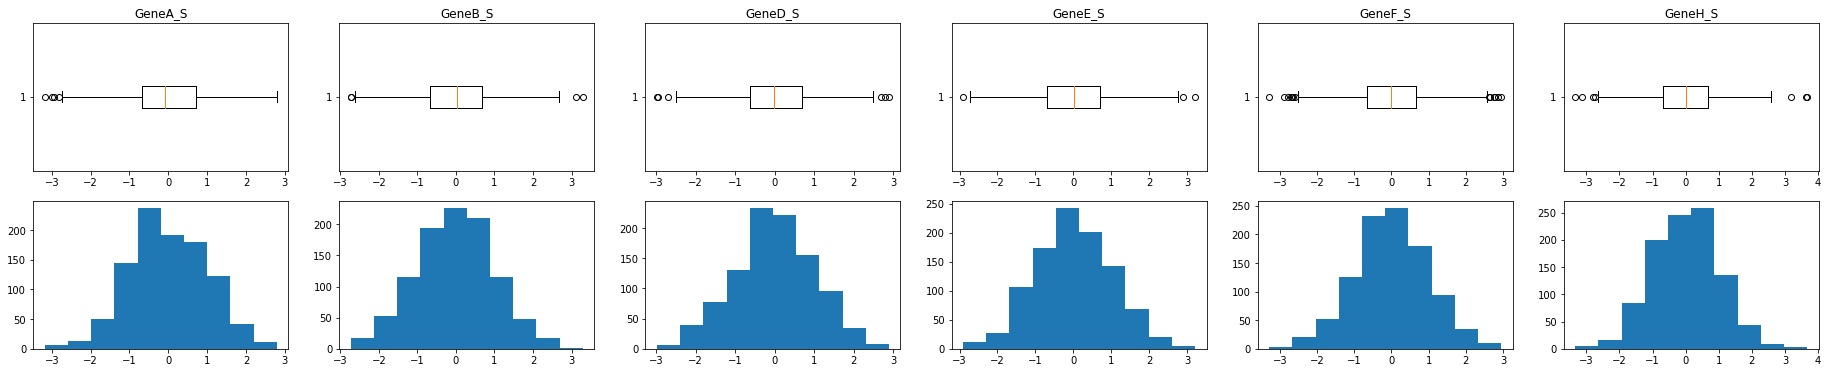

In [ ]:
no_id_list=list(predictors.columns)

fig, ax = plt.subplots(2,len(no_id_list), figsize=(32, 6))
i=0
for field in no_id_list:
  ax[0,i].boxplot(predictors[field], vert=False)
  ax[0,i].set_title(field) 
  i+=1
i=0
for field in no_id_list:
  ax[1,i].hist(predictors[field])
  i+=1
plt.show()

In [ ]:
with pm.Model() as model_reg:
  # Priors for regression model
  beta = pm.Normal('beta', mu=0, sd=0.25, shape=n_predictors)
  intercept = pm.Normal('intercept', mu=0, sd=3)

  # Priors for mixture model
  std_A = pm.HalfNormal('sd1', sd=2)
  nu = pm.Exponential("nu", lam=1/29) + 1

  # Likelihood
  mu = intercept + pm.math.dot(beta, predictors.T) 
  obs_A = pm.StudentT("obs_A", mu=mu, nu=nu, sd=std_A, observed=data_s)

  # Sample from the posterior distribution
  trace_reg = pm.sample(20000, tune=4000, step=pm.Metropolis())


Sampling chain 1, 0 divergences: 100%|██████████| 24000/24000 [00:23<00:00, 1030.87it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0360a53070>],
      dtype=object)

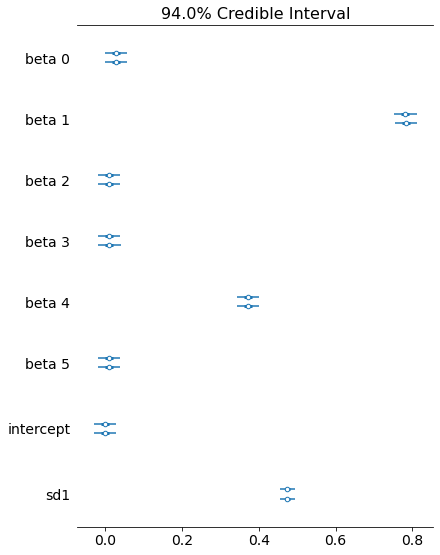

In [ ]:
az.plot_forest(trace_reg, var_names=['beta', 'intercept', 'sd1'])

    From this plot we can see that beta1 and beta4 have a higher correlation 
    coefficient than the rest. Which means, GeneA and GeneF are the most 
    important for the DoublingTime of the cell. 

    Because GeneC and GeneF are perfectly correlated, this would mean that 
    GeneC would also be inportant for the DoublingTime. However, this might 
    also mean that GeneF influences the expression of GeneC (or the other way 
    arround) and then one or both influence the DoublingTime.

/usr/local/lib/python3.8/dist-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSuppli

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f035f2c52b0>,
      dtype=object)

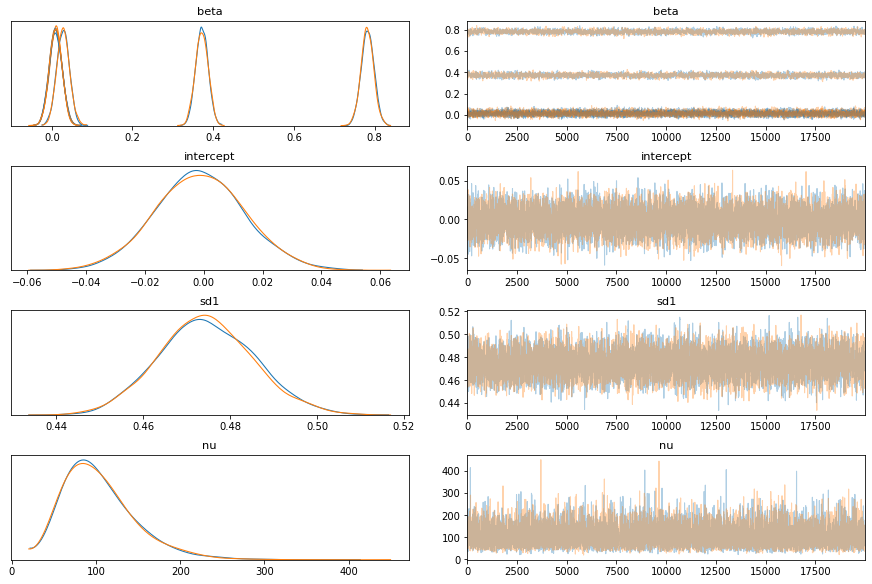

In [ ]:
pm.traceplot(trace_reg)

The parameters converge.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f035ef92f70>,
      dtype=object)

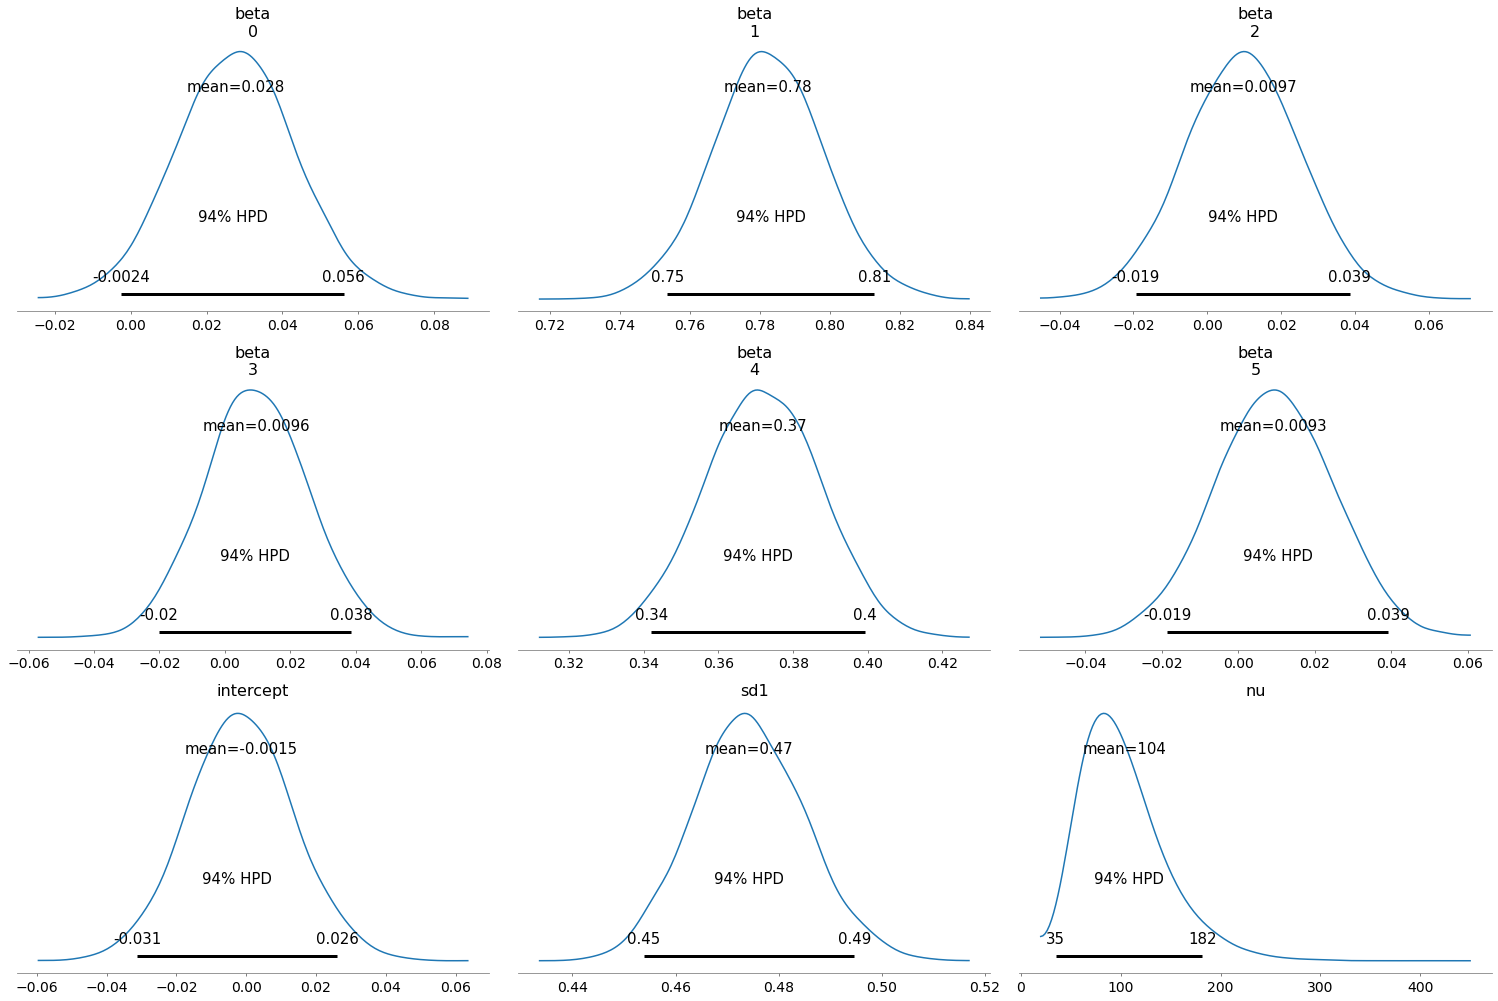

In [ ]:
pm.plot_posterior(trace_reg)

In [ ]:
az.summary(trace_reg)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta[0],0.028,0.016,-0.002,0.056,0.000,0.000,1791.0,1791.0,1792.0,3364.0,1.0
beta[1],0.782,0.016,0.754,0.813,0.000,0.000,2055.0,2053.0,2055.0,3120.0,1.0
beta[2],0.010,0.015,-0.019,0.039,0.000,0.000,1872.0,1872.0,1875.0,3099.0,1.0
beta[3],0.010,0.016,-0.020,0.038,0.000,0.000,1931.0,1931.0,1931.0,3222.0,1.0
beta[4],0.372,0.015,0.342,0.399,0.000,0.000,2034.0,2034.0,2035.0,3516.0,1.0
beta[5],0.009,0.015,-0.019,0.039,0.000,0.000,1885.0,1885.0,1885.0,3288.0,1.0
intercept,-0.002,0.015,-0.031,0.026,0.000,0.000,7445.0,6764.0,7436.0,7382.0,1.0
sd1,0.474,0.011,0.454,0.495,0.000,0.000,7181.0,7172.0,7196.0,7480.0,1.0
nu,103.852,43.035,35.029,181.919,0.463,0.334,8630.0,8291.0,8834.0,9891.0,1.0


### Performance of model

In [ ]:
betas = trace_reg['beta'].mean(axis=0)
alpha = trace_reg.intercept.mean()

In [ ]:
# using the model to predict the DoublingTime

predicted_values = alpha + predictors.GeneA_S*betas[0] + predictors.GeneB_S*betas[1] \
+ predictors.GeneD_S*betas[2] + predictors.GeneE_S*betas[3] \
+ predictors.GeneF_S*betas[4] + predictors.GeneH_S*betas[5]

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


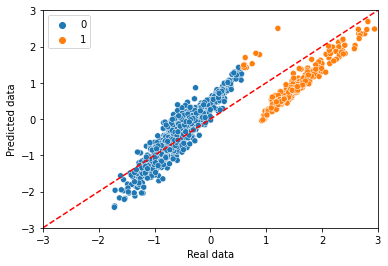

In [ ]:
# plotting the real and predicted values

sns.scatterplot(data_s, predicted_values, hue=labels)
plt.xlabel("Real data")
plt.ylabel("Predicted data")
plt.plot([-3, 3], [-3, 3], ls="--", c="red")
plt.ylim(-3, 3)
plt.xlim(-3, 3)
plt.show()

The plot shows that the model doens a good job of predicting the values, however it's not perfect. 

## LR model with SKLearn

I expected a better correlation between the real and the predicted data, so I made a MR model with SKLearn. Furthermore, I wanted to see how the model would perform if I only included the non-correlated fields, and how it would perform if I included all the fields.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# assigning the fields for the 2 models : one with only non-correlated and one with all fields
X = df_s[['GeneA_S', 'GeneB_S', 'GeneD_S', 'GeneE_S', 'GeneF_S', 'GeneH_S']]
X_all = df_s[['GeneA_S', 'GeneB_S', 'GeneC_S', 'GeneD_S', 'GeneE_S', 'GeneF_S', 'GeneG_S', 'GeneH_S',]]
y = df_s['DoublingTime_S']

# spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_all_train, X_all_test, y_xall_train, y_xall_test = train_test_split(X_all, y, test_size=0.2, random_state=42)

# building the models
SK_LR_model = LinearRegression()
SK_LR_model.fit(X_train, y_train)

SK_LR_X_all_model = LinearRegression()
SK_LR_X_all_model.fit(X_all_train, y_xall_train)

# making predictions
predictions = SK_LR_model.predict(X_test)
predictions_X_all = SK_LR_X_all_model.predict(X_all_test)

# getting scores of the models with the test data
score = SK_LR_model.score(X_test, y_test)
score_X_all = SK_LR_X_all_model.score(X_all_test, y_xall_test)

In [ ]:
print('Model - only included the non-correlated fields'.upper())
print("\tScore: ", score)
print("\tAlpha: ", SK_LR_model.intercept_)
print("\tCoefficients: ", SK_LR_model.coef_)
print()
print('Model - all fields'.upper())
print("\tScore: ", score_X_all)
print("\tAlpha: ", SK_LR_X_all_model.intercept_)
print("\tCoefficients: ", SK_LR_X_all_model.coef_)

MODEL - ONLY INCLUDED THE NON-CORRELATED FIELDS
	Score:  0.803614849295306
	Alpha:  -0.008122600385506665
	Coefficients:  [0.02553564 0.76100189 0.00122435 0.00150833 0.36966977 0.01819751]

MODEL - ALL FIELDS
	Score:  0.8046546269246977
	Alpha:  -0.008160871097897909
	Coefficients:  [0.02631029 0.76077295 0.14500975 0.00140606 0.00136203 0.22523021
 0.00906661 0.00906661]


    It seems as though both models have similar performance.

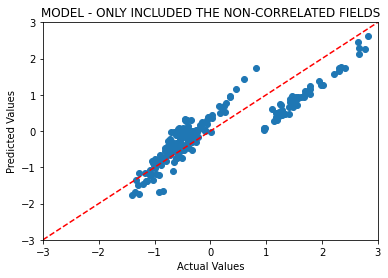

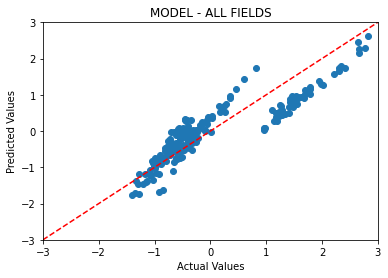

In [ ]:
plt.scatter(y_test, predictions)
plt.plot([-3, 3], [-3, 3], ls="--", c="red")
plt.ylim(-3, 3)
plt.xlim(-3, 3)
plt.title('Model - only included the non-correlated fields'.upper())
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

print()

plt.scatter(y_test, predictions_X_all)
plt.plot([-3, 3], [-3, 3], ls="--", c="red")
plt.ylim(-3, 3)
plt.xlim(-3, 3)
plt.title('Model - all fields'.upper())
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

    The plots are the same, and also are very similar to the prediction plots 
    for the bayesian approach.

## Faulty Model

In this part I use all the fields for the regression model. In the end, I get the same performance like as model where I use only the non-correlated. But, even thought the performance is the same, the correlation coefficitens do not converge. 

I believe that the reason for this is: 

> In a multiple regression model, the regression coefficients are estimated using the method of least squares. This involves minimizing the sum of the squared differences between the predicted values and the actual values of the response variable. Each coefficient represents the change in the response variable associated with a one-unit change in the corresponding predictor variable, holding all other variables constant.

> However, when two or more predictor variables are highly correlated with each other, it becomes difficult for the model to distinguish the separate effects of each variable on the response variable. This is because the effects of the correlated variables tend to be confounded, or mixed together, in the model.

> As a result, the model may allocate some of the effect of one variable to another variable that is highly correlated with it, and vice versa. This can lead to unstable and unreliable estimates of the regression coefficients, as the coefficients may be influenced by the presence of other highly correlated variables in the model.

> Furthermore, when two or more predictor variables are highly correlated with each other, it is difficult to estimate the individual effects of each variable with high precision. This can result in large standard errors for the coefficients, which can make it difficult to assess the statistical significance of the coefficients and to make reliable predictions based on the model.

In [ ]:
n_predictors_all = 8
predictors_all = df_s[['GeneA_S', 'GeneB_S', 'GeneC_S', 'GeneD_S', 'GeneE_S', 'GeneF_S', 'GeneG_S', 'GeneH_S']]

In [ ]:
with pm.Model() as model_reg_all:

  # Priors for regression model
  beta = pm.Normal('beta', mu=0, sd=0.25, shape=n_predictors_all)
  intercept = pm.Normal('intercept', mu=0, sd=3)

  # Priors for mixture model
  std_A = pm.HalfNormal('sd1', sd=2)
  nu = pm.Exponential("nu", lam=1/29) + 1

  # Likelihood
  mu = intercept + pm.math.dot(beta, predictors_all.T)
  obs_A = pm.StudentT("obs_A", mu=mu, nu=nu, sd=std_A, observed=data_s)

  # Sample from the posterior distribution
  trace_reg_all = pm.sample(25000, tune=4000, step=pm.Metropolis())


Sampling chain 1, 0 divergences: 100%|██████████| 29000/29000 [00:30<00:00, 947.02it/s]
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


/usr/local/lib/python3.8/dist-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSuppli

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f03607d99d0>,
      dtype=object)

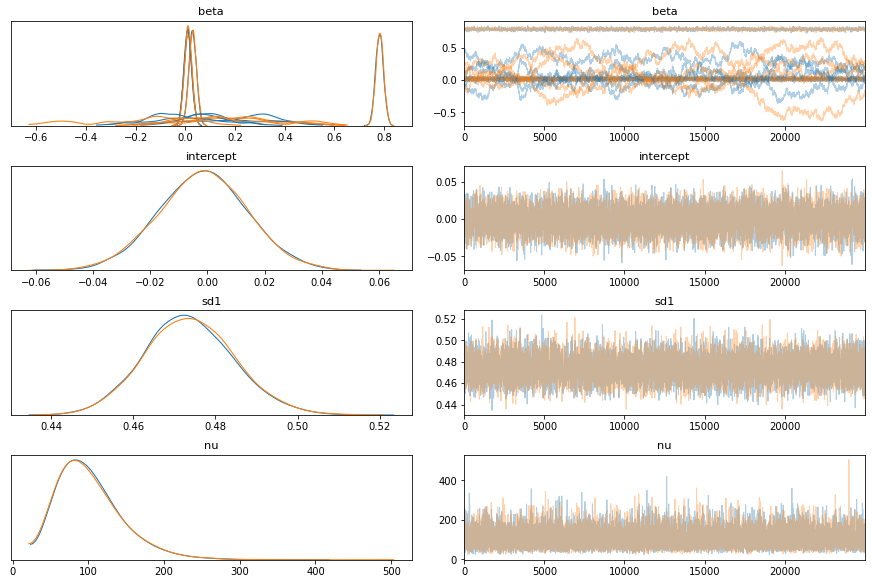

In [ ]:
pm.traceplot(trace_reg_all)

    Here the non-convergence of the betas is apparent.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f03615993a0>,
      dtype=object)

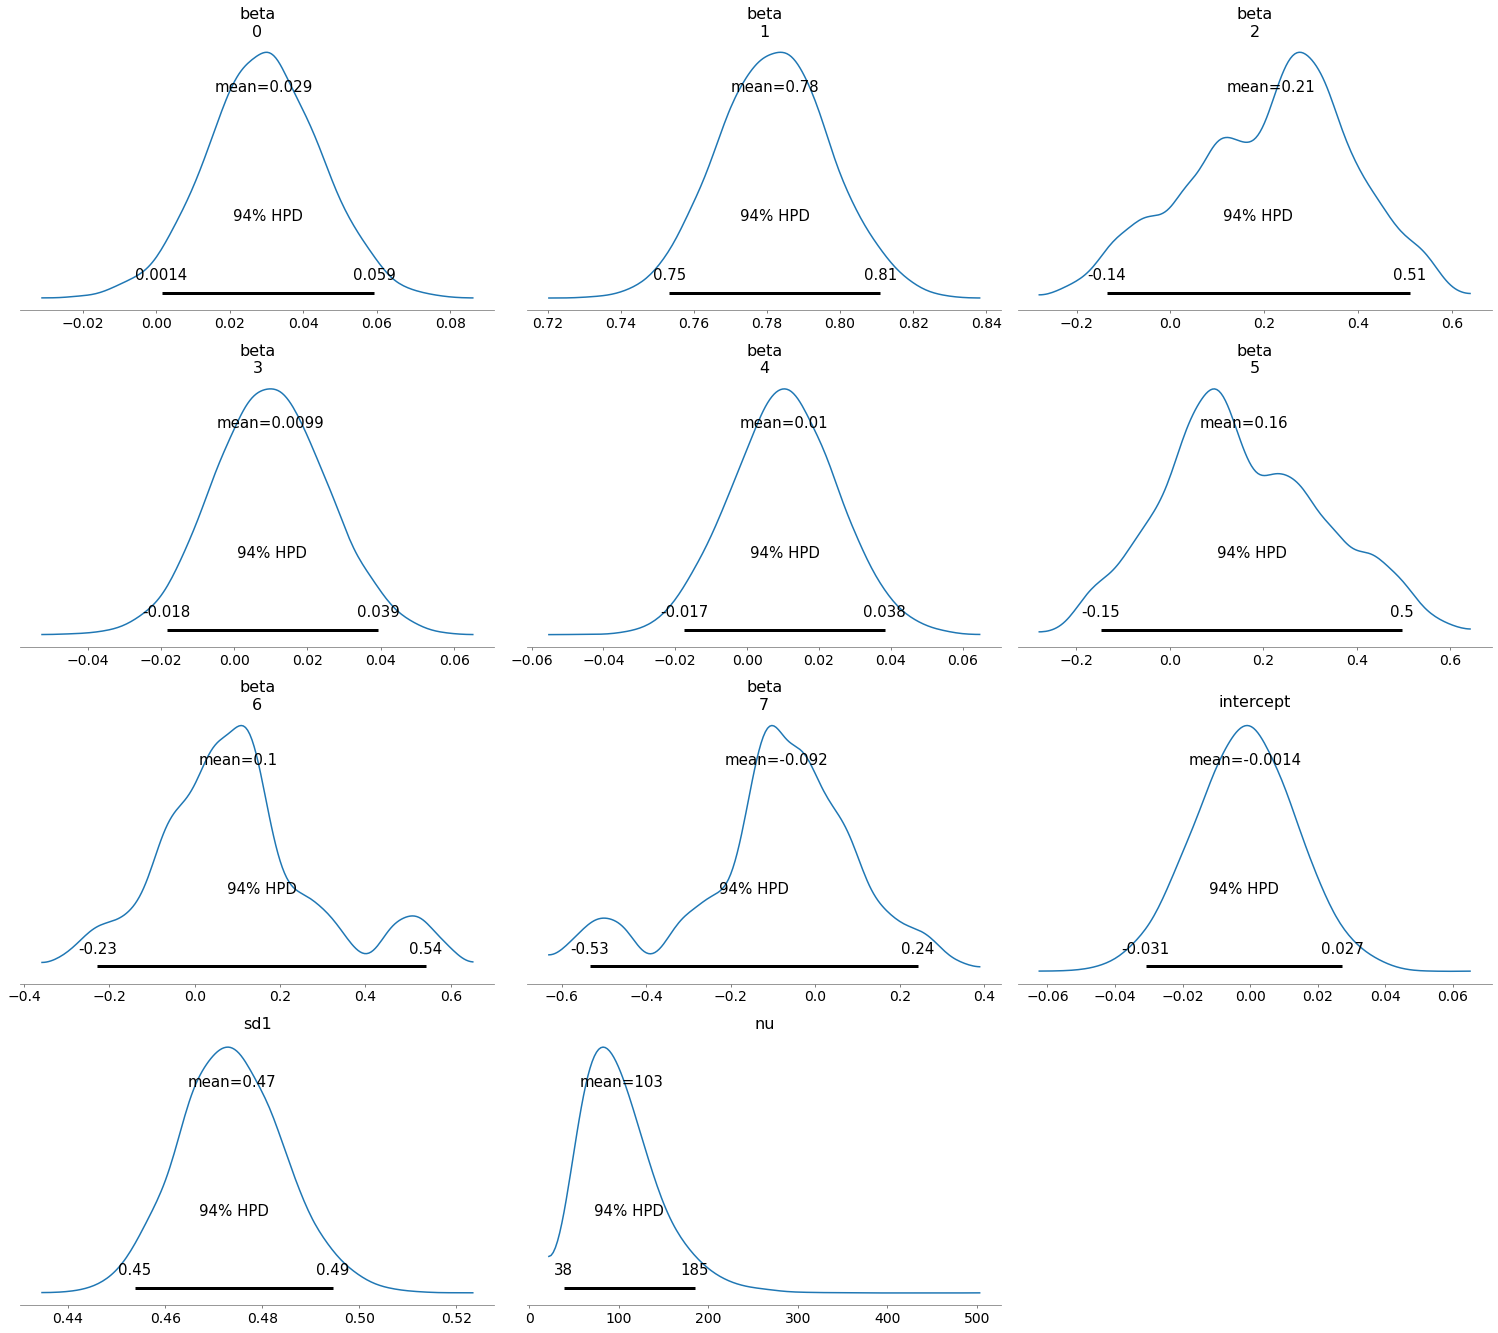

In [ ]:
pm.plot_posterior(trace_reg_all)

    The betas with uneven distribution curves are: 2,5,6,7. 
    These correspond to: GeneC, GeneF, GeneG, GeneH. 
    As seen in the pairplot, the correlated genes are: GeneC and GeneF, 
    and GeneC and GeneF. Therefore, this behaviour makes sence.

In [ ]:
betas_all = trace_reg_all['beta'].mean(axis=0)
alpha_all = trace_reg_all.intercept.mean()

In [ ]:
predicted_values_all = alpha_all + predictors_all.GeneA_S*betas_all[0] + predictors_all.GeneB_S*betas_all[1] \
+ predictors_all.GeneC_S*betas_all[2] + predictors_all.GeneD_S*betas_all[3] + predictors_all.GeneE_S*betas_all[4] \
+ predictors_all.GeneF_S*betas_all[5] + predictors_all.GeneG_S*betas_all[6] + predictors_all.GeneH_S*betas_all[7]

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


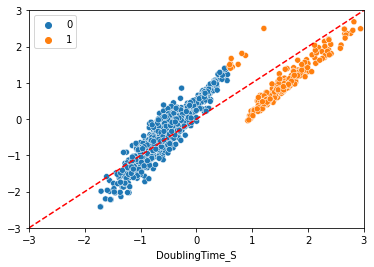

In [ ]:
sns.scatterplot(data_s, predicted_values_all, hue=labels)
plt.plot([-3, 3], [-3, 3], ls="--", c="red")
plt.ylim(-3, 3)
plt.xlim(-3, 3)
plt.show()

    Here, it appers that the performance is similar to the model where I didn't 
    use all the fields, so I plot both of the predicted values of both models, 
    There is a perfect correlation. It appers that the models peformance is not 
    dependant on non-collinearity, however convergence of the betas is.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


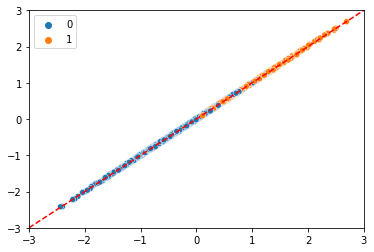

In [ ]:
sns.scatterplot(predicted_values, predicted_values_all, hue=labels)
plt.plot([-3, 3], [-3, 3], ls="--", c="red")
plt.ylim(-3, 3)
plt.xlim(-3, 3)
plt.show()

## Conclusions: 

From this model we can see that the biggest importance for the $DoublingTime$ is the expression of $GeneA$ and $GeneF(GeneC)$. Furthermore, all the regression coefficients are positive (*in the model without correlated genes*), even if the coefficient is $10^{-3}$. This means that a increase in the expression of any of the genes (but especially the A, F, C) would lead to an increase in the DoublingTime. Therefore, I think that A, F, and C would repressent potent tumor suppressor genes.

In the model with all genes, there is one negative correlation coefficient, however this is a result of multicollinearity - because the value increases counting twice for the correlated field, the model tries to compensate by lowering the value, ei. setting a negative coefficient.

It's difficult to specify a set treshold point for the expression in these two (three) genes, that once surpassed increases/decreases the doubling time to the extent where the cell is in the other group. Generally, for those 3 genes, increased expression will lead to increased doubling time; whereas for the other genes, a bigger increase in expression would be needed to increase the doubling time. 